In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, Input, GlobalAveragePooling2D, Dense


In [2]:
train_path = "../Computer Vision Masterclass/Datasets/cat_dog_2/training_set"
test_path = "../Computer Vision Masterclass/Datasets/cat_dog_2/test_set"

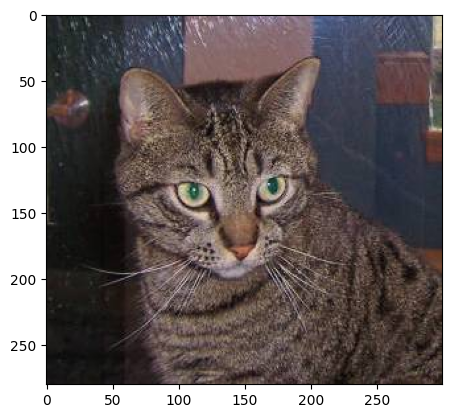

In [3]:
img = cv2.imread(train_path + "/cat/cat.1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
plt.imshow(img)

In [4]:
# ImageDataGenerator to apply data augmentation, randomly translating, rotating, resizing, etc.
train_datagen = ImageDataGenerator(rescale=1. / 255)
train_datagen.fill_mode='constant'
train_datagen.horizontal_flip=True
train_datagen.zoom_range=[0.8, 1.2]
train_datagen.rotation_range=20
train_datagen.shear_range=10
train_datagen.brightness_range = [0.75, 1.5]



#making image as 227X227 for input of alexnet
# train = train_datagen.flow_from_directory(train_path, target_size=(227,227), class_mode='categorical')
train = train_datagen.flow_from_directory(train_path, target_size=(64, 64), shuffle=True, class_mode='categorical')


Found 4000 images belonging to 2 classes.


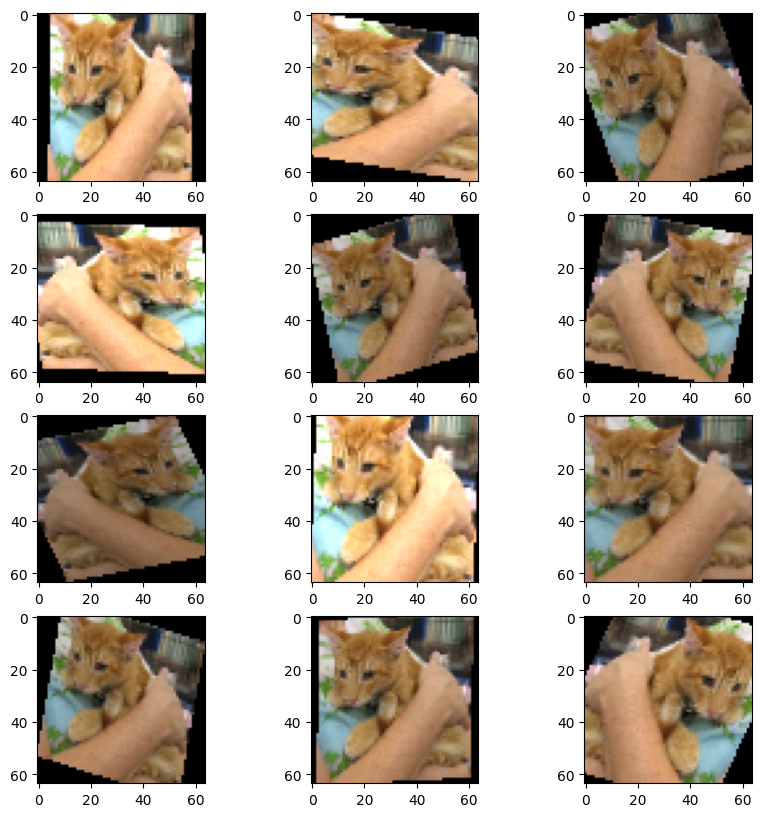

In [5]:
fig , axs = plt.subplots(4,3 ,figsize = (10,10))

axs[0][0].imshow(train[1][0][0])
axs[0][1].imshow(train[1][0][0])
axs[0][2].imshow(train[1][0][0])
axs[1][0].imshow(train[1][0][0])
axs[1][1].imshow(train[1][0][0])
axs[1][2].imshow(train[1][0][0])
axs[2][0].imshow(train[1][0][0])
axs[2][1].imshow(train[1][0][0])
axs[2][2].imshow(train[1][0][0])
axs[3][0].imshow(train[1][0][0])
axs[3][1].imshow(train[1][0][0])
axs[3][2].imshow(train[1][0][0])

In [6]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test = test_datagen.flow_from_directory(test_path, target_size=(64,64), shuffle=False, class_mode='categorical')

Found 1000 images belonging to 2 classes.


In [13]:


def depthwise_separable_conv(X, pointwise_filters, strides=(1, 1)):
    # Depthwise Convolution
    X = DepthwiseConv2D(kernel_size=(3, 3), strides=strides, padding='same')(X)     # Normal Conv2D gave 9k parameters, Depthwise gave 320
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # Pointwise Convolution
    X = Conv2D(pointwise_filters, kernel_size=(1, 1), strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    return X


def mobilenet_block(X, pointwise_filters, strides=(1, 1)):
    X = depthwise_separable_conv(X, pointwise_filters, strides)

    return X


def MobileNet(input_shape=(224, 224, 3), classes=1000):
    X_input = Input(input_shape)

    # Initial Conv Layer
    X = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # MobileNet Blocks
    X = mobilenet_block(X, pointwise_filters=64, strides=(1, 1))
    X = mobilenet_block(X, pointwise_filters=128, strides=(2, 2))
    X = mobilenet_block(X, pointwise_filters=128, strides=(1, 1))
    X = mobilenet_block(X, pointwise_filters=256, strides=(2, 2))
    X = mobilenet_block(X, pointwise_filters=256, strides=(1, 1))
    X = mobilenet_block(X, pointwise_filters=512, strides=(2, 2))

    for _ in range(5):
        X = mobilenet_block(X, pointwise_filters=512, strides=(1, 1))

    X = mobilenet_block(X, pointwise_filters=1024, strides=(2, 2))
    X = mobilenet_block(X, pointwise_filters=1024, strides=(1, 1))

    # Average Pooling
    X = GlobalAveragePooling2D()(X)

    # Output layer
    X = Dense(classes, activation='softmax')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='MobileNet')

    return model



network = MobileNet(input_shape=(64, 64, 3), classes=2)

network.summary()


Model: "MobileNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_81 (ReLU)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_26             │ (None, 32, 32, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_82 (ReLU)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 32, 32, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_83 (ReLU)                 │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_27             │ (None, 16, 16, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_84 (ReLU)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 16, 16, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_85 (ReLU)                 │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_28             │ (None, 16, 16, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_86 (ReLU)                 │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,241,858 (12.37 MB)

 Trainable params: 3,219,970 (12.28 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [14]:
# Define the learning rate you want to use
learning_rate = 0.0001  # Example learning rate

# Instantiate the Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile your neural network model with the customized optimizer
network.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history = network.fit(train, epochs=20)

Epoch 1/20


KeyboardInterrupt: 

In [15]:
predictions = network.predict(test)
predictions

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step


array([[0.5448276 , 0.45517245],
       [0.3963762 , 0.6036238 ],
       [0.50819135, 0.4918086 ],
       ...,
       [0.00257369, 0.99742633],
       [0.05934684, 0.9406532 ],
       [0.02854954, 0.9714505 ]], dtype=float32)

In [16]:
# predicted values
predictions = np.argmax(predictions, axis=1)
predictions 

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,

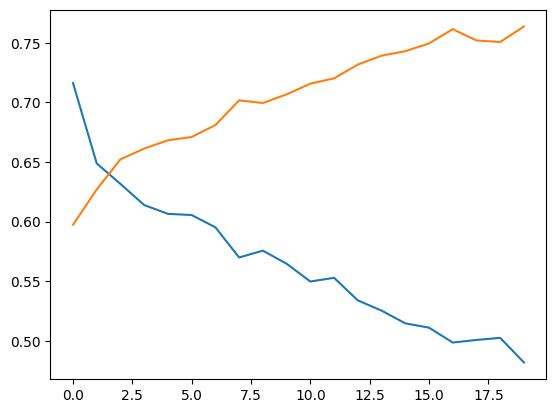

In [17]:
plt.plot(history.history['loss'] )
plt.plot(history.history['accuracy'] )

In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(test.classes, predictions)

0.665